# Evaluate model

In [10]:
""" Imports """

import torch
import numpy as np
import random

from torch.utils.data import DataLoader, Subset
from torchsummary import summary

import eval_functions

from dataset_utils import get_data_paths, ECGDataset
from solver import Solver

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load model

In [2]:
""" Config """

config = {
    'model_path': 'saves/ConvModelAE_train_28_17_50_44_100E',
    'model_epoch': None,  
    'num_samples': 20,
    
    'subset_size_train': 1000,
    'subset_size_test': 8000,
    
    'split': [.8, .1, .1],
}

PLOT_COLOR = 'black'

GENDER_ENUM = np.vectorize(lambda t: 'M' if t == 0 else 'F')

device = 'cpu'

""" Add a seed to have reproducible results """

seed = 123
torch.manual_seed(seed)


""" Load model and solver """

model_path, solver_path = eval_functions.get_model_solver_paths(
    save_path=config['model_path'],
    epoch=config['model_epoch']
)

print("Loading model and solver")
solver = Solver()
solver.load(solver_path, device, only_history=True)
model = torch.load(model_path, map_location=device)

Getting model and solver paths
Loading model and solver


In [3]:
""" Print training config """

print('""" Training Config """\n')
max_len = max([len(key) for key in solver.config.keys()])
for key in solver.config.keys():
    print("{key: <{fill}}: {val}".format(key=key, val=solver.config[key], fill=max_len))

""" Training Config """

data_path             : data/sleep_dataset
fs                    : 256
segment_length        : 8
load_gender           : True
split                 : [0.8, 0.1, 0.1]
seed                  : 123
instance_normalization: True
high_pass             : True
notch                 : True
noise                 : 0.01
intensity_range       : [0.9, 1.1]
save_path             : saves
num_workers           : 4
do_overfitting        : False
num_overfit           : 10
max_num_patients      : None
batch_size            : 4
num_epochs            : 100
save_interval         : 10
model                 : ConvModelGender
use_embedding         : False
encoder_path          : 
learning_rate         : 0.0005
lr_decay_factor       : 0.8
lr_decay_patience     : 2
weight_decay          : 0
l1_penalty            : 0
rec_weight            : 1.0
gender_weight         : 1.0
dropout               : 0.0
show_samples          : False
show_gradient_flow    : False
continue_training     : False
m

## Show solver history

Stop reason: 
Stop time: 7743.279195s


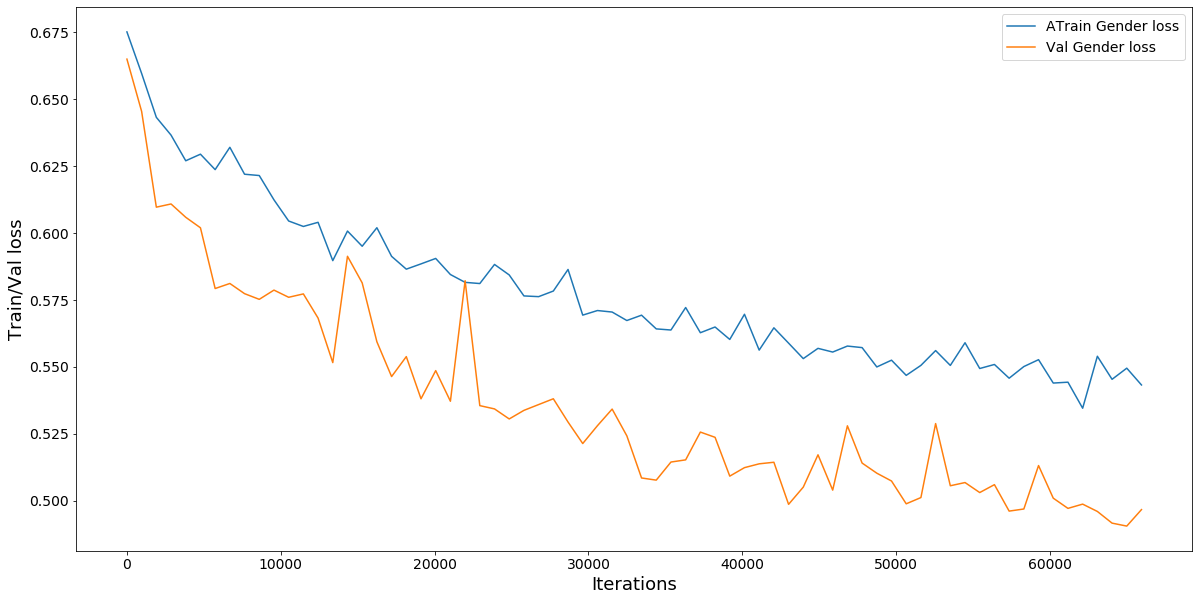

Final training gender loss: 0.543287790355529
Final validation gender loss: 0.4967305501175534


In [6]:
""" Show loss history """

eval_functions.show_solver_history(solver, plot_train=True, color=PLOT_COLOR)

## Load datasets

In [12]:
""" Load datasets """

data_paths = get_data_paths('data/sleep_dataset/')
random.shuffle(data_paths)

print("Found {} patients in total".format(len(data_paths)))

# Apply same split as during training
split1 = int(np.floor(config['split'][0] * len(data_paths)))
split2 = int(np.floor((config['split'][0] + config['split'][1]) * len(data_paths)))

train_paths = data_paths[:split1]
val_paths = data_paths[split1:split2]
test_paths = data_paths[split2:]

train_dataset = ECGDataset(
    data_paths=train_paths,
    is_test=False,
    fs=solver.config['fs'],
    seg_length=solver.config['segment_length'],
    instance_normalization=solver.config['instance_normalization'],
    high_pass=solver.config['high_pass'],
    notch=solver.config['notch'],
)

test_dataset = ECGDataset(
    data_paths=test_paths,
    is_test=True,
    fs=solver.config['fs'],
    seg_length=solver.config['segment_length'],
    instance_normalization=solver.config['instance_normalization'],
    high_pass=solver.config['high_pass'],
    notch=solver.config['notch'],
)

train_loader = DataLoader(train_dataset, batch_size=config['subset_size_train'])
test_loader = DataLoader(test_dataset, batch_size=config['subset_size_test'])

Found 40 patients in total


In [13]:
x_train, gender_train = next(iter(train_loader))
gender_train = np.array(gender_train)
print("Loaded train subset")
x_test, gender_test = next(iter(test_loader))
gender_test = np.array(gender_test)
print("Loaded test subset")

Loaded train subset
Loaded test subset


In [14]:
""" Print model summary """

print(summary(model, input_size=x_train.shape[1:], device=device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 2048]              80
       BatchNorm1d-2             [-1, 16, 2048]              32
              ReLU-3             [-1, 16, 2048]               0
         MaxPool1d-4             [-1, 16, 1024]               0
         ConvBlock-5             [-1, 16, 1024]               0
            Conv1d-6             [-1, 16, 1024]           1,280
       BatchNorm1d-7             [-1, 16, 1024]              32
              ReLU-8             [-1, 16, 1024]               0
         MaxPool1d-9              [-1, 16, 512]               0
        ConvBlock-10              [-1, 16, 512]               0
           Conv1d-11              [-1, 32, 512]           2,560
      BatchNorm1d-12              [-1, 32, 512]              64
             ReLU-13              [-1, 32, 512]               0
        MaxPool1d-14              [-1, 

## Gender Classification

In [15]:
if model.predict_gender:
    _, gender_pred_train = model(x_train)
    gender_pred_train = torch.nn.functional.softmax(gender_pred_train, dim=1)
    _, gender_pred_train = gender_pred_train.max(dim=1)
    eval_functions.plot_gender_prediction(gender_train, np.array(gender_pred_train), color=PLOT_COLOR)
    
    _, gender_pred_test = model(x_test)
    gender_pred_test = torch.nn.functional.softmax(gender_pred_test, dim=1)
    _, gender_pred_test = gender_pred_test.max(dim=1)
    eval_functions.plot_gender_prediction(gender_test, np.array(gender_pred_test), color=PLOT_COLOR)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

## T-SNE on last layer

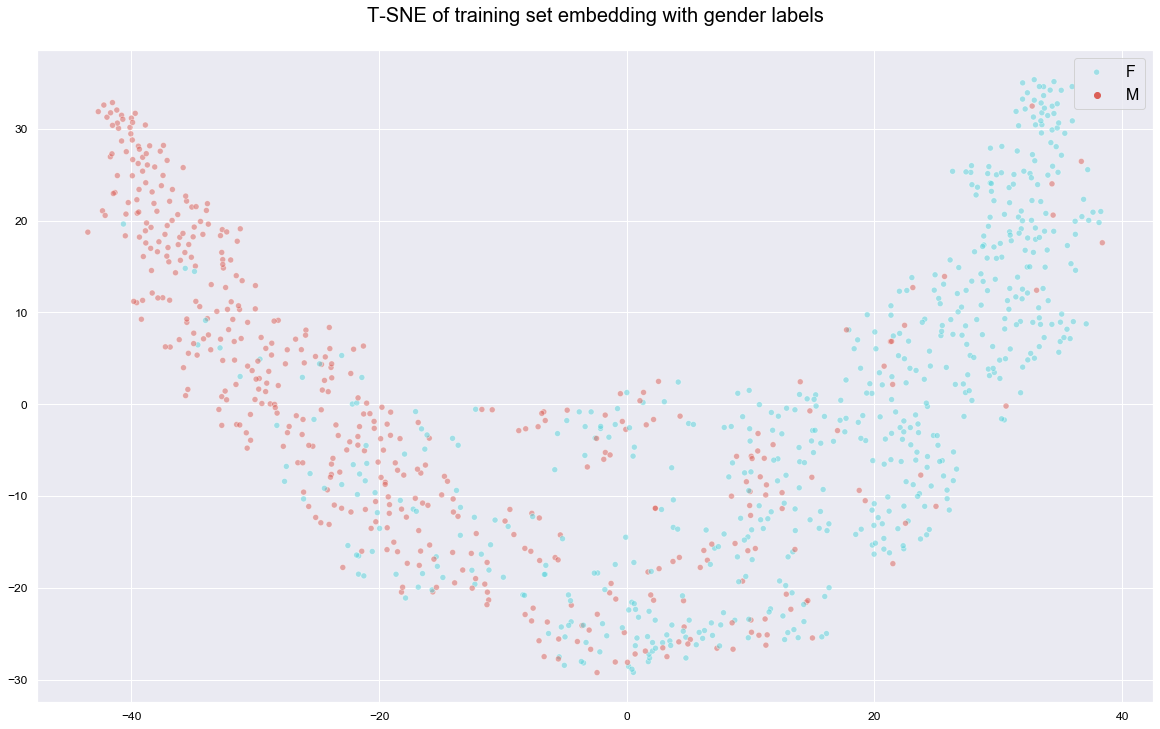

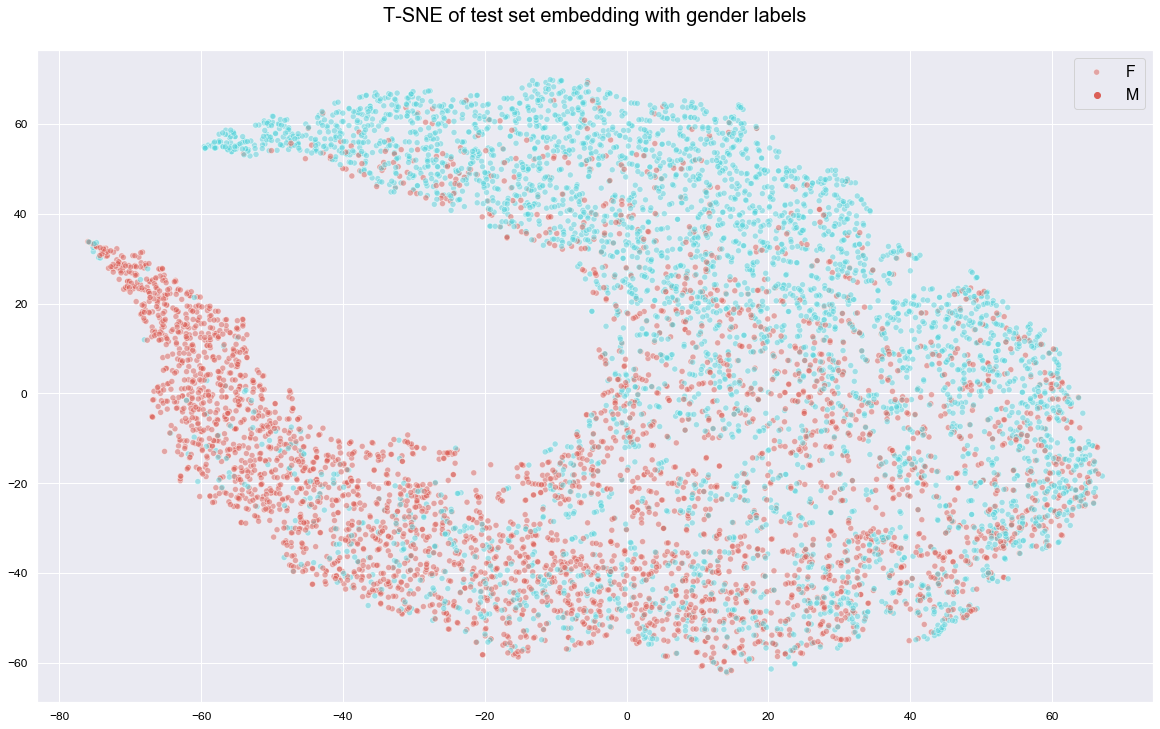

In [11]:
if model.predict_gender:
    features_train = model.linear(model.encoder(x_train).view(x_train.shape[0], -1)).detach()
    features_test = model.linear(model.encoder(x_test).view(x_test.shape[0], -1)).detach()

    eval_functions.plot_t_sne(features_train, gender_train, ['training set', 'gender'], color=PLOT_COLOR)
    eval_functions.plot_t_sne(features_test, gender_test, ['test set', 'gender'], color=PLOT_COLOR)

## Saliency maps of correct classification

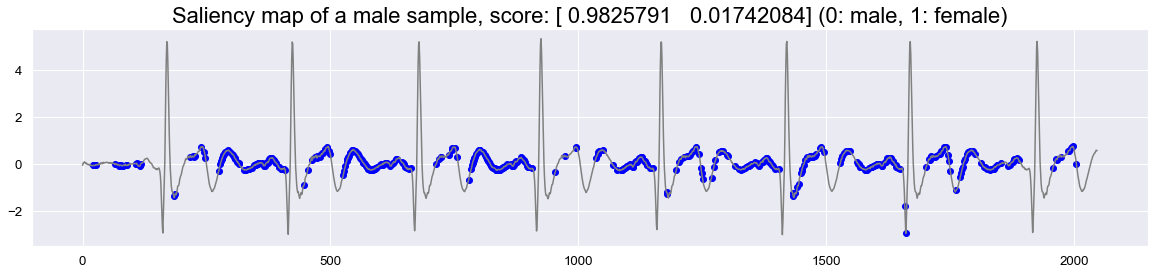

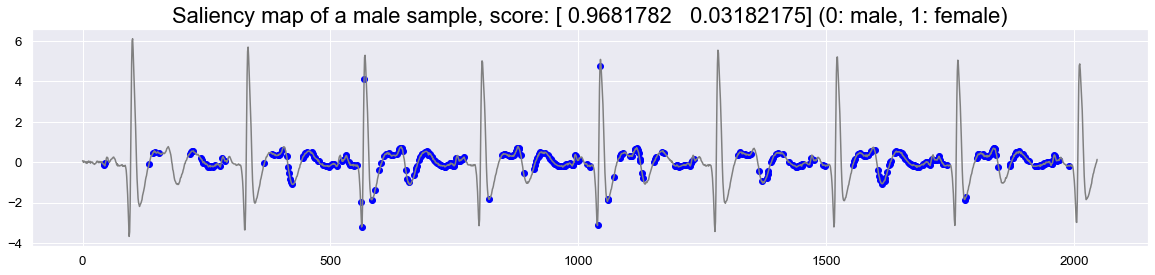

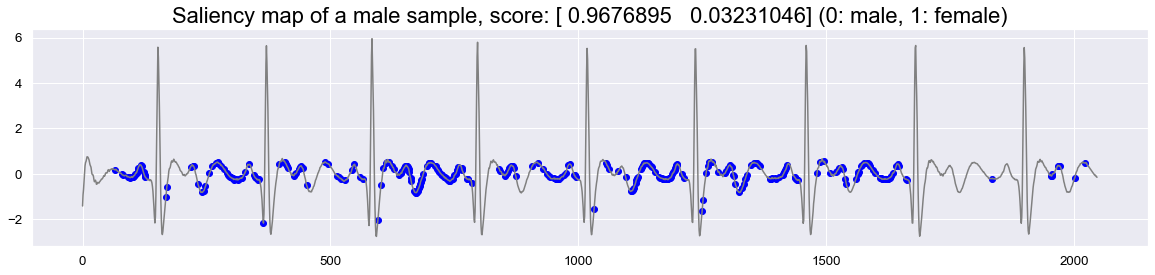

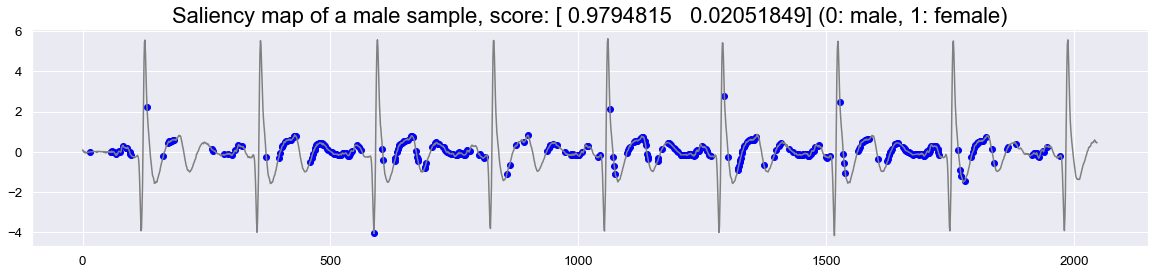

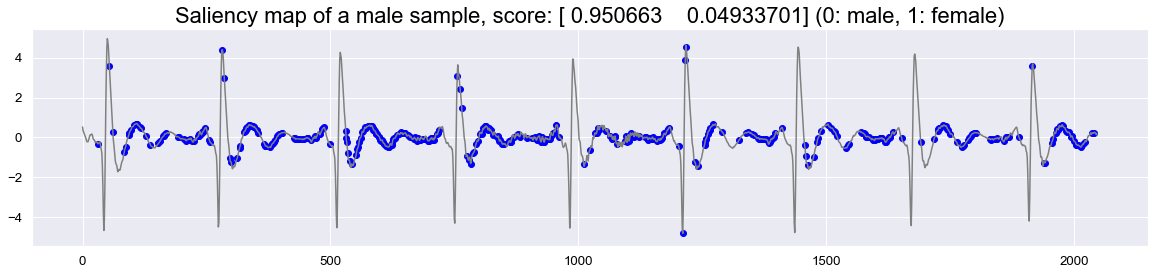

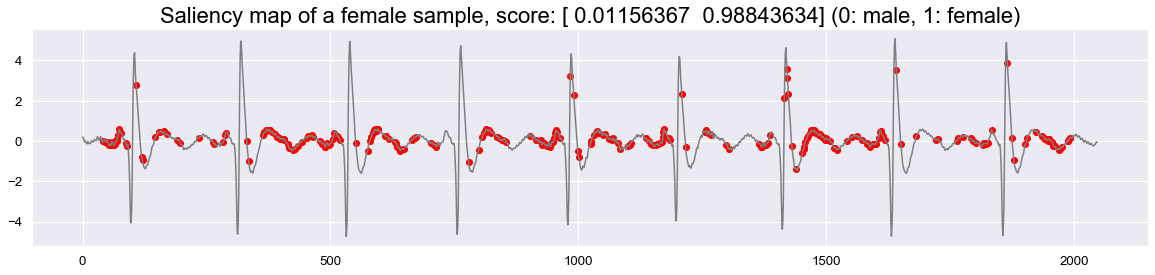

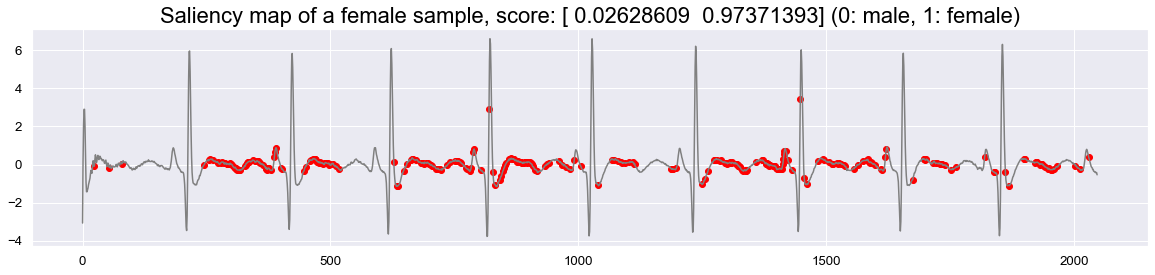

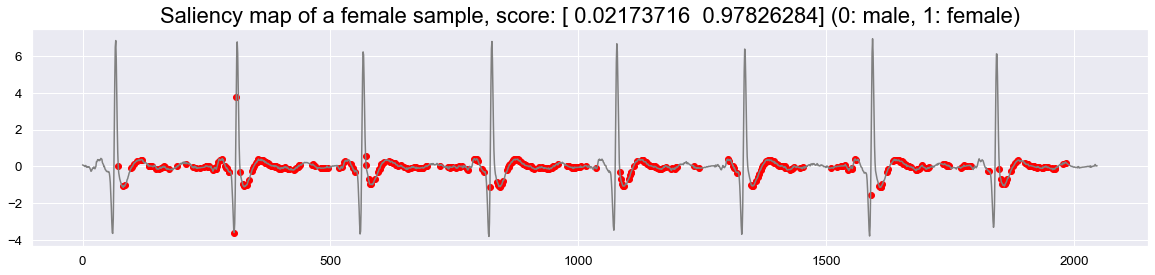

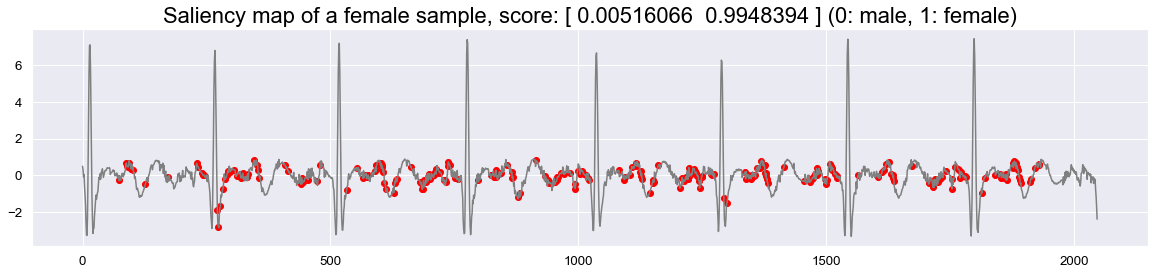

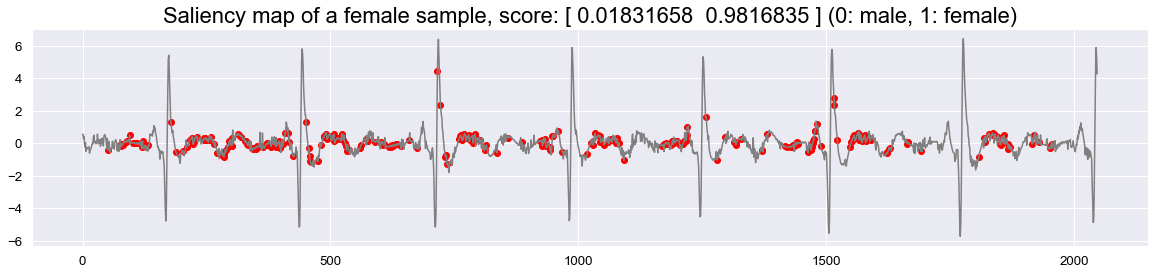

In [12]:
if model.predict_gender:
    eval_functions.plot_selected_saliency_maps(model, x_test, gender_test, 5, plot_threshold=0.01, color=PLOT_COLOR)

## Saliency maps of wrong classifications

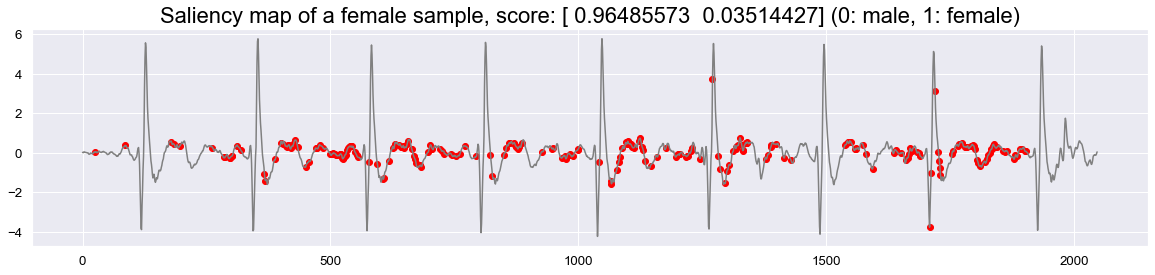

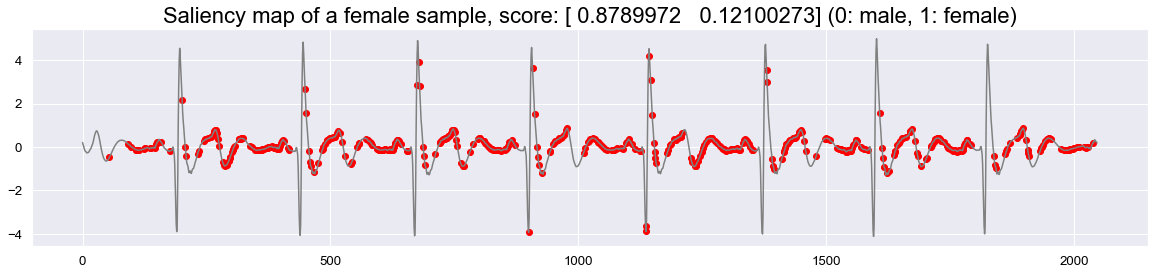

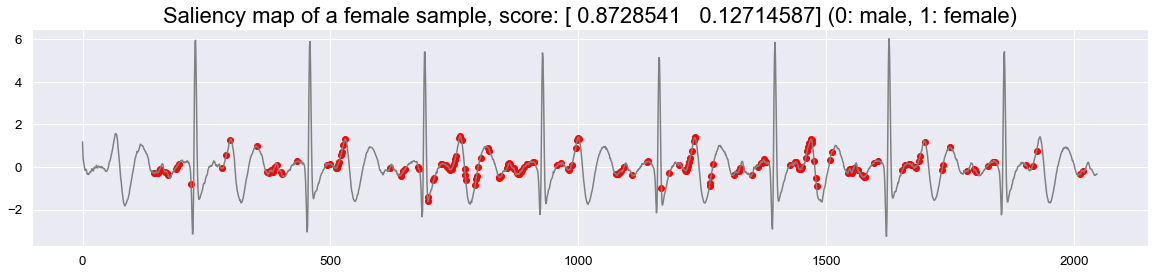

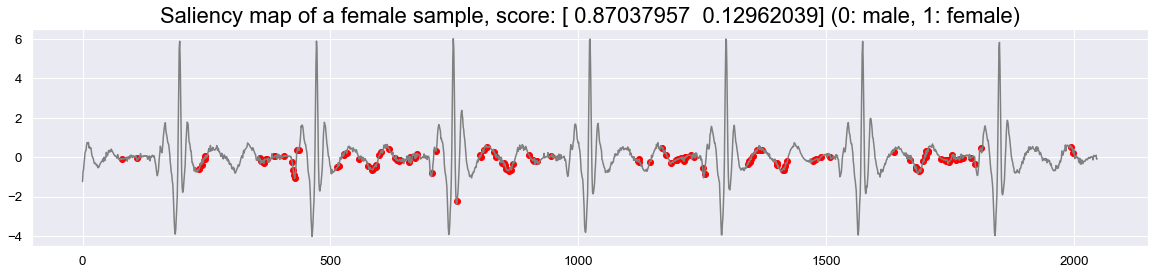

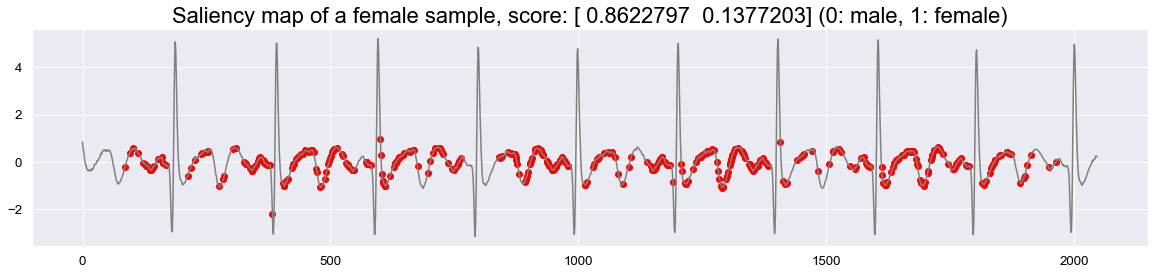

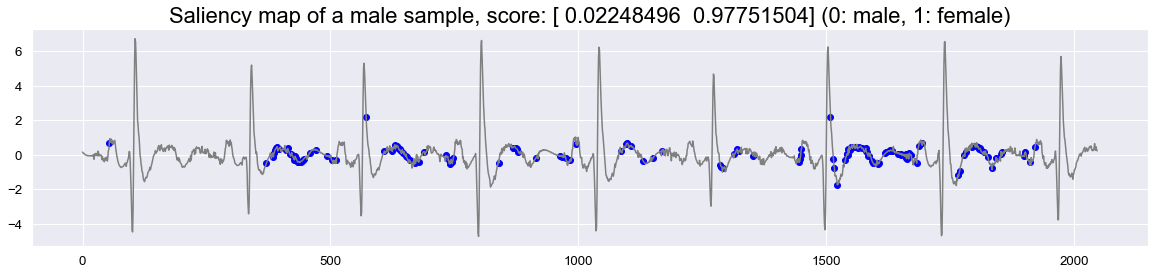

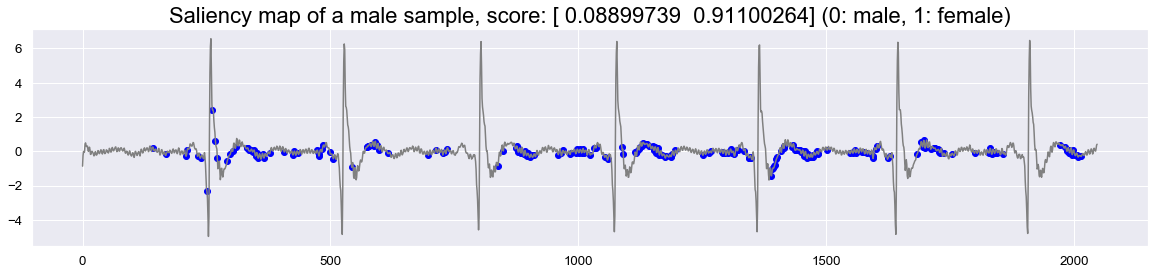

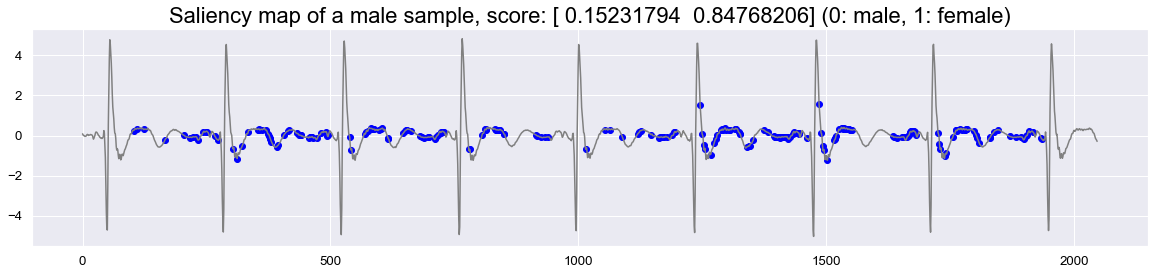

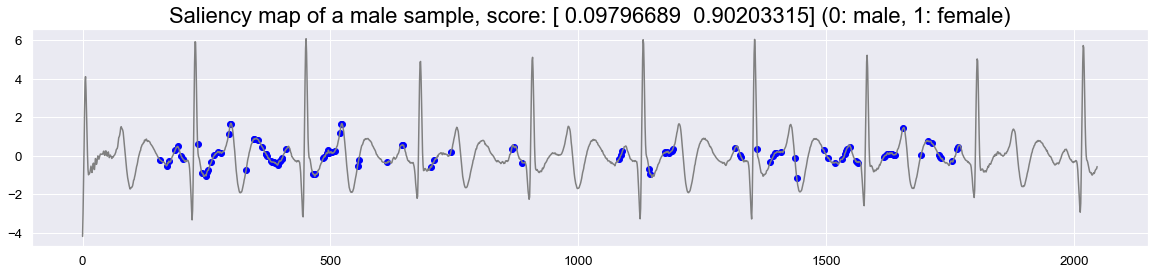

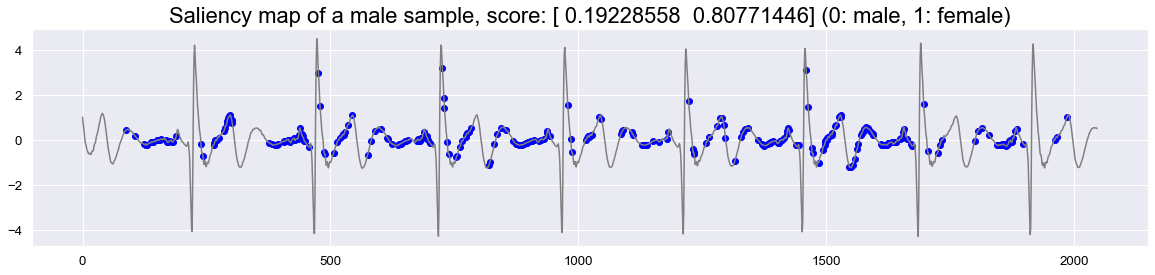

In [13]:
if model.predict_gender:
    eval_functions.plot_selected_saliency_maps(
        model, x_test, gender_test, 5, 
        inverted=True, score_threshold=0.8, 
        plot_threshold=0.015, color=PLOT_COLOR)

## Visualize activations

/Users/felix/Virtualenvs/ECGfe/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


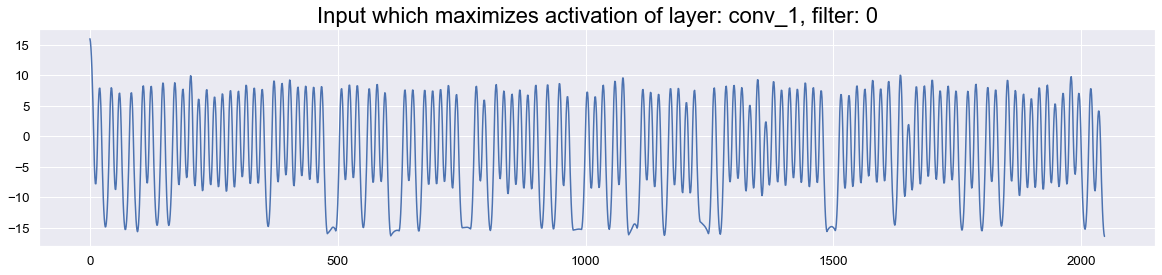

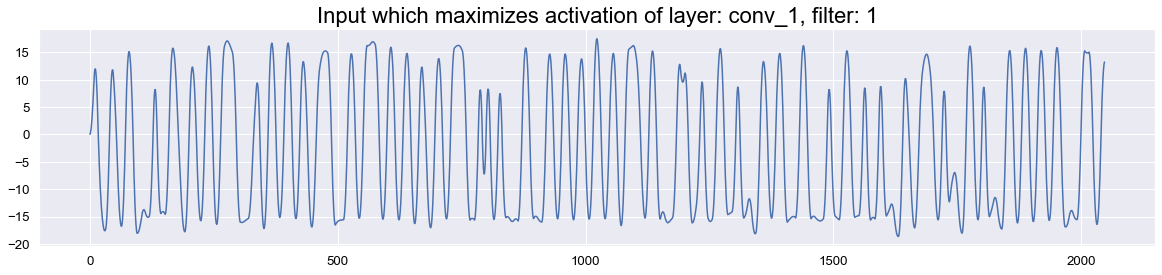

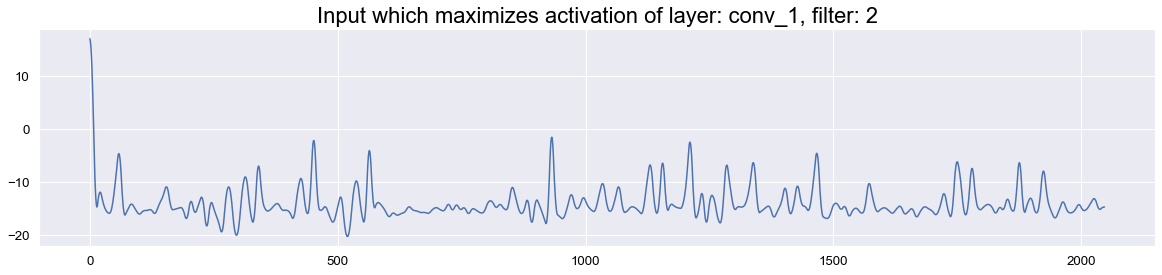

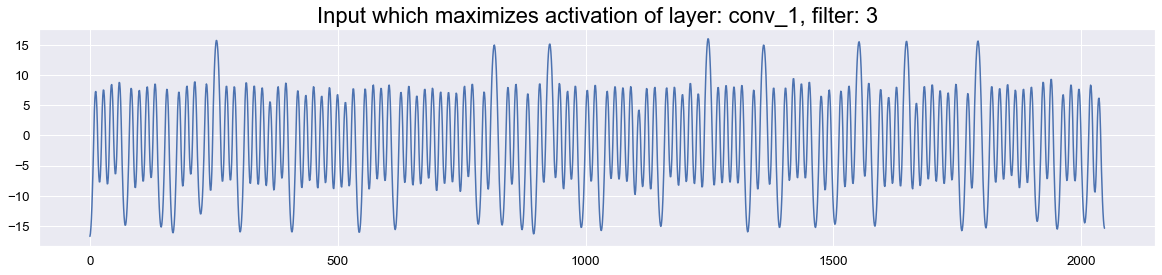

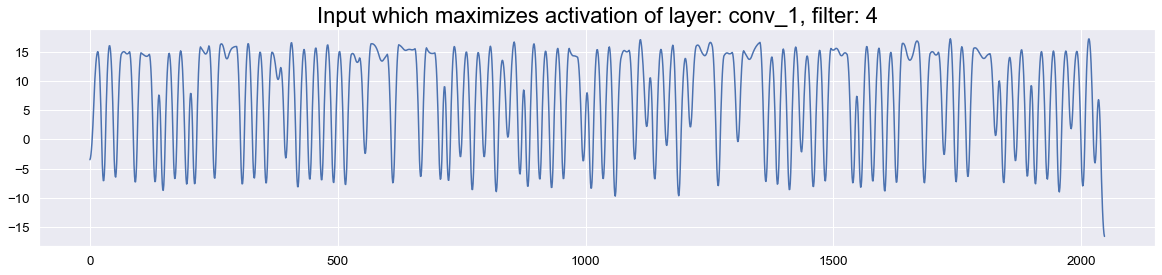

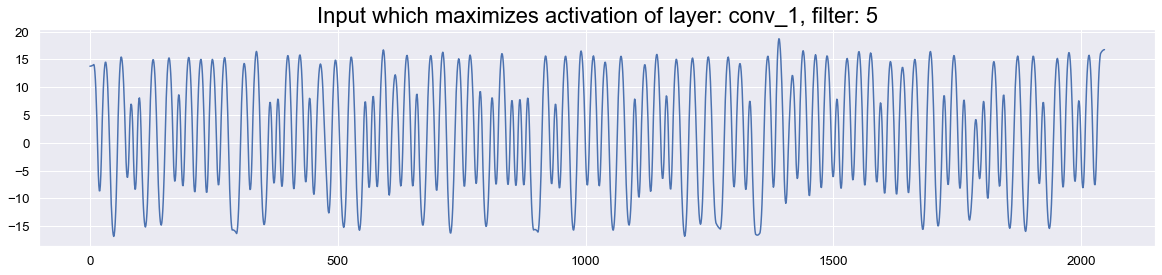

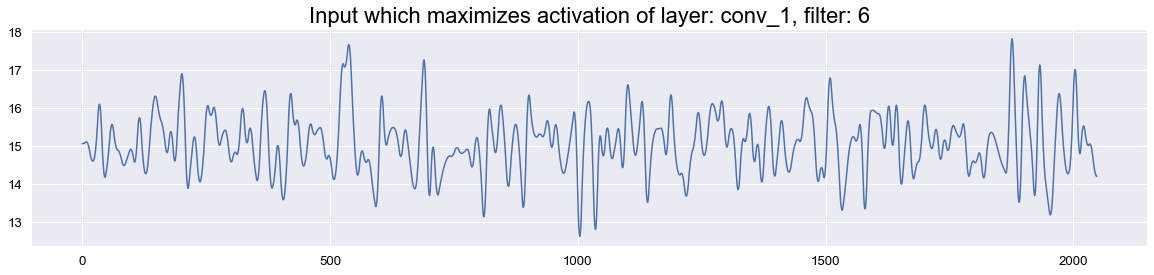

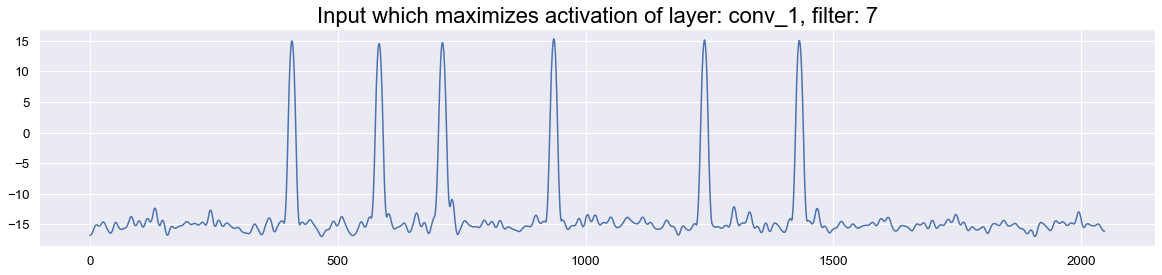

In [14]:
for filt in range(8):
    eval_functions.create_signal_which_maximizes_activation(
        model.encoder, 
        input_size=solver.config['fs'] * solver.config['segment_length'], 
        layer=0, 
        filt=filt,
        upscaling_steps=3,
        opt_steps=150,
        color=PLOT_COLOR
    )

# Evaluate Autoencoder

In [15]:
""" Show reconstruction samples """

if model.is_autoencoder:
    eval_functions.show_reconstruction(
        dataset=train_dataset, 
        model=model, 
        num_samples=config['num_samples'],
        color=PLOT_COLOR
    )

In [16]:
""" Compute embeddings """

if model.is_autoencoder:
    X_train, gender_train = next(iter(
        torch.utils.data.DataLoader(train_dataset, batch_size=config['subset_size_train'])))
    X_test, gender_test = next(iter(
        torch.utils.data.DataLoader(test_dataset, batch_size=config['subset_size_test'])))

    gender_train = np.array(gender_train)
    gender_test = np.array(gender_test)

    embedding_train = model.encoder(X_train).view(X_train.shape[0], -1).detach()
    embedding_test = model.encoder(X_test).view(X_test.shape[0], -1).detach()

In [17]:
""" T-SNE on embedding """

if model.is_autoencoder:
    eval_functions.plot_t_sne(embedding_test, gender_test, ['test set', 'gender'], color=PLOT_COLOR)